In [1]:
import tifffile
import numpy as np
from matplotlib import pyplot as plt
import os
import napari
from scipy.optimize import curve_fit
from scipy.interpolate import UnivariateSpline
from scipy.optimize import curve_fit
from scipy.ndimage import zoom
from natsort import os_sorted
import tkinter
from tkinter import filedialog
from scipy import ndimage
import cv2
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.patches import Rectangle
from skimage import filters
import cupy as cp
from cupyx.scipy.ndimage import gaussian_filter
import json
import matplotlib.ticker as tck

In [2]:
def load_datasets(paths):
    stacks = []
    for path in paths:
        if path.endswith('.tif'):
            stack = tifffile.imread(path)
            stacks.append(stack)
        else:
            # open folder
            files = os_sorted(os.listdir(path))
            stack = []
            for file in files:
                if file.endswith('.tif'):
                    stack.append(tifffile.imread(os.path.join(path, file)))
            stacks.append(np.array(stack))
    return np.array(stacks)

def shift_stack_lateral(stack, xy_shift=(0,0)):
    rolled = np.roll(stack, xy_shift[0], axis=[0])
    shift = np.roll(rolled,xy_shift[1], axis=[1])  

def reshape_tiff_data(data, num_channels):
    # Initialize the output array with the desired shape (3, 250, 500, 500)
    zsteps = len(data)//num_channels
    output = np.zeros((num_channels, zsteps, data.shape[1], data.shape[2]), dtype=np.uint16)


    # Iterate over the z-steps
    for z in range(len(data)//num_channels):
        if z % 2 == 0:
            for c in range(num_channels):
                output[c, z] = data[z * num_channels + c]
        else:
            for c in range(num_channels):
                ci = num_channels - c - 1
                output[ci, z] = data[z * num_channels + c]
    return output

def apply_norm(stack, sigma=200):
    img_gpu = cp.asarray(stack)
    sigma_stack = [0, sigma, sigma]
    norm = gaussian_filter(img_gpu, sigma_stack)

    # division
    norm_stack = img_gpu / norm
    return norm_stack.get()

In [3]:
# ask path with tkinter
#root = tkinter.Tk()
#root.withdraw()
#path = filedialog.askdirectory() + '/'

path = 'C:/Users/alm/Documents/ImSwitchConfig/recordings/240902/final_rec_thorlabscam/'
print(path)

files = os_sorted(os.listdir(path))
stack =  np.array([tifffile.imread(path + file) for file in files if file.endswith('.tif')])

metadata_file = 'metadata.json'
if metadata_file in files:
    metadata = json.load(open(os.path.join(path, metadata_file)))
    z_spacing = metadata['sample_stage_step_size']
    xy_pixelsize = metadata['detector_pixel_size']
    channels = [f"ex {metadata['channels'][i]['laser_name']} em {metadata['channels'][i]['emission_filter']}" for i in metadata['channels']]

else:
    metadata = None
    z_spacing=1.1261
    xy_pixelsize=0.345
    channels=['channel 1', 'channel 2']

stack = reshape_tiff_data(stack, len(channels))
print(stack.shape)

C:/Users/alm/Documents/ImSwitchConfig/recordings/240902/final_rec_thorlabscam/
(2, 500, 2160, 4096)


In [4]:
viewer = napari.Viewer()

C:\Users\alm\AppData\Roaming\Python\Python39\site-packages\networkx\utils\backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))


In [5]:
viewer.add_image(stack, colormap='turbo')

<Image layer 'stack' at 0x1593d3ad550>

In [6]:
stack = stack[:,:219,:,:]
viewer.add_image(stack, colormap='turbo')

<Image layer 'stack [1]' at 0x1593cd9ddc0>

In [7]:
center_FOV = 1250
size = 500

cropped_stack = stack[:,:,center_FOV-size//2:center_FOV+size//2]
viewer.add_image(cropped_stack, colormap='turbo')
print(cropped_stack.shape)

(2, 219, 500, 4096)


In [8]:
# extracting all the beads
#import cupyx.scipy.ndimage as ndimage
from scipy import ndimage
from tqdm import tqdm
from scipy.ndimage import gaussian_filter1d

def connected_component_analysis_2d(stack, threshold=10000):
    centroids_all_slices = []
    
    for z in tqdm(range(stack.shape[0])):  # Loop over each 2D slice in the stack
        binary_mask = (stack[z, :, :] >= threshold).astype(np.uint8)
        labeled_mask, num_features = ndimage.label(binary_mask)
        
        # Calculate centroids for the 2D slice
        centroids = ndimage.center_of_mass(binary_mask, labeled_mask, range(1, num_features + 1))
        
        # Store centroids for each slice along with the z-index
        centroids_with_z = [(z, *centroid) for centroid in centroids]
        [centroids_all_slices.append(i) for i in centroids_with_z]

    return centroids_all_slices

def connected_component_analysis(stack, threshold = 10000):
    #max_plane = np.max(stack, axis = 0)
    #stack = cp.asarray(stack)
    binary_mask = (stack >= threshold).astype(np.uint8)
    binary_mask = binary_mask.astype(np.uint16)
    #binary_mask = cp.asarray(binary_mask)
    #viewer.add_image(binary_mask)

    # connected component analysis
    labeled_mask, num_features = ndimage.label(binary_mask)
    label_range = range(1, num_features + 1)
    centroids = ndimage.center_of_mass(binary_mask, labeled_mask, label_range)
    return centroids
'''
def fwhm_along_axis(y, spacing, plot = False):
    # Maximum normalization
    y = gaussian_filter1d(y, sigma=1)
    y_norm = [i/max(y) for i in y]
    # create x values for plot based on the intensity values y considering the spacing
    x = [(i) * spacing for i in range(len(y_norm))]
    y_norm = y_norm-np.max(y_norm)/2
    # find fwhm of plot
    peak = np.max(y_norm)
    half_max = peak / 2

    # Shift s down by half-maximum to find where it crosses zero
    s_shifted = y_norm - half_max

    # Fit a spline to the shifted data
    spline = UnivariateSpline(x, s_shifted, s=0)
    
    if len(spline.roots()) == 1:
        fwhm = 0
    elif len(spline.roots()) == 2:
        r1, r2 = spline.roots()
        fwhm = abs(abs(r1) - abs(r2))
    else:
        fwhm = 0
        #print(len(spline.roots()))
        #plt.plot(x, s_shifted)
        #plt.show()
    # return fwhm
    return [fwhm]
'''
def fwhm_along_axis(y, spacing, plot = False):
    # Maximum normalization
    y_norm = [i/max(y) for i in y]
    # create x values for plot based on the intensity values y considering the spacing
    x = [(i) * spacing for i in range(len(y_norm))]

    # find fwhm of plot
    spline = UnivariateSpline(x, y_norm-np.max(y_norm)/2, s=0)
    r1, r2 = spline.roots()
    fwhm = abs(abs(r1) - abs(r2))

    # return fwhm
    return [fwhm]

def get_fwhm(bbox, spacing_xy, spacing_z):
    # find max intensity
    #print(bbox.shape)
    max_coor = np.unravel_index(np.argmax(bbox), bbox.shape)
    xy_maxint = np.max(bbox, axis=0)

    xz_maxint = np.max(bbox, axis=1)
    # get intensity lines
    y_line = xy_maxint[int(max_coor[1]),:]
    x_line = xy_maxint[:,int(max_coor[2])]
    z_line = xz_maxint[:,int(max_coor[2])]
    # get fwhm
    fwhm_x = fwhm_along_axis(x_line, spacing_xy)
    fwhm_y = fwhm_along_axis(y_line, spacing_xy)
    fwhm_z = fwhm_along_axis(z_line, spacing_z)
    # return fwhm
    return [fwhm_x[0], fwhm_y[0], fwhm_z[0]], max_coor[0]

def apply_bbox_and_fwhm(img, psf, bbox_size = 10, spacing_xy = 0.06484, spacing_z = 0.06484):
    
    # make bounding box
    upper = [int(psf[1] + bbox_size/2), int(psf[2] + bbox_size/2)]
    lower = [int(psf[1] - bbox_size/2), int(psf[2] - bbox_size/2)]
    bbox = img[:,lower[0]:upper[0], lower[1]:upper[1]]
    #print(bbox.shape)
    if 0 in bbox.shape:
        #print('bbox empty in one dimension')
        return [0,0,0], 0
        
    else:
        fwhm_list, coor_z = get_fwhm(bbox, spacing_xy, spacing_z)
    return np.array(fwhm_list)*1000, coor_z

def get_points(stack, bbox_size=20, threshold=50, spacing_xy=0.345, spacing_z=1.1261):
    points = {}
    all_fwhm = {}
    i=0
    if len(stack.shape) == 3:
        stack = np.expand_dims(stack, axis=0)

    # TODO implement for multiple channels    
    components = connected_component_analysis_2d(stack[0], threshold=threshold)
    print('CCA done')
    for c in range(stack.shape[0]):
        all_fwhm[c] = []
        points[c] = []
    for point in tqdm(components):
        for c in range(stack.shape[0]):
            try:
                fwhm_xyz, coor_z = apply_bbox_and_fwhm(stack[c], point, bbox_size=bbox_size, spacing_xy=spacing_xy, spacing_z=spacing_z)
                all_fwhm[c].append(fwhm_xyz)
                points[c].append([point[0], point[1], point[2]])
            except ValueError:
                #print(fwhm_xyz)
                i+=1
                continue
                
    print(f'{i} beads were not analyzed')


    return points, all_fwhm
points, all_fwhm = get_points(cropped_stack, spacing_z = z_spacing, threshold=220)

100%|██████████| 219/219 [00:18<00:00, 12.15it/s]


CCA done


100%|██████████| 6303/6303 [00:34<00:00, 182.77it/s]

2470 beads were not analyzed


(5104, 3)
0
1
2
(5032, 3)
0
1
2


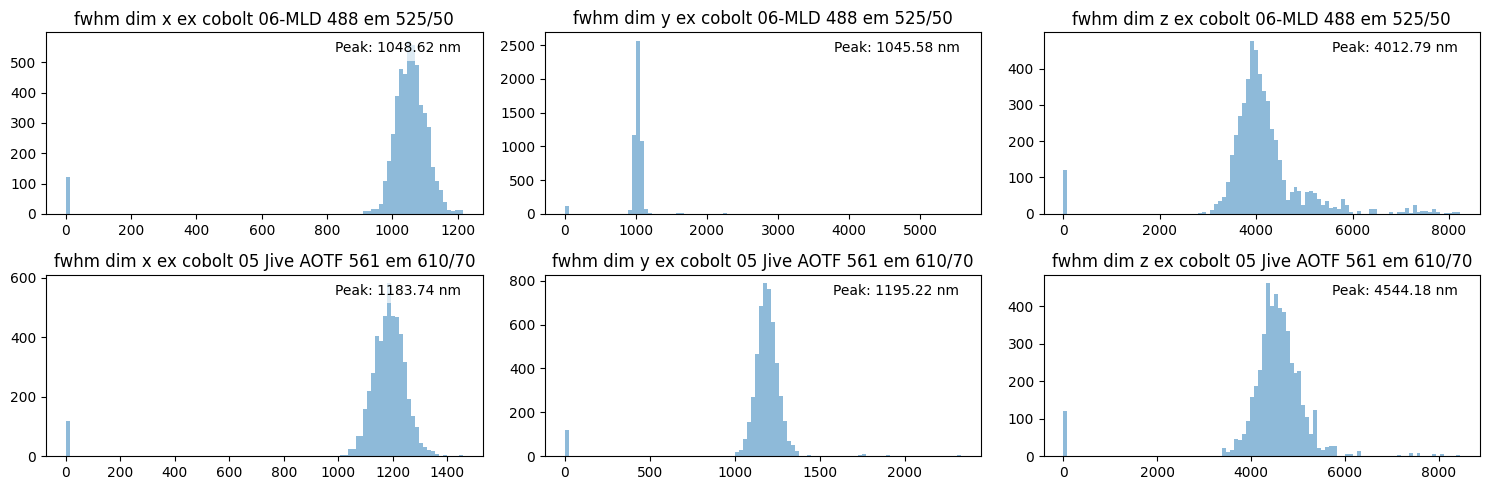

In [9]:
bins = 100

# all_fwhm shape (3228, 3)
def add_peak_textbox(ax, data, bins=bins):
    hist, bin_edges = np.histogram(data, bins=40)  # Use the same number of bins as in the plot
    peak_bin_index = np.argmax(hist)
    peak_value = (bin_edges[peak_bin_index] + bin_edges[peak_bin_index + 1]) / 2  # Use the middle of the bin
    ax.text(0.95, 0.95, f'Peak: {peak_value:.2f} nm', 
            transform=ax.transAxes, 
            horizontalalignment='right', 
            verticalalignment='top',
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

axes = ['x', 'y', 'z']

fig, axs = plt.subplots(len(all_fwhm.keys()), 3, figsize=(15, len(all_fwhm.keys())*2.5))

for c in all_fwhm.keys():
    fwhm_channel = np.array(all_fwhm[c])
    print(fwhm_channel.shape)   
    ch = channels[c]
    for dims in range(fwhm_channel.shape[1]):
        print(dims)
        if len(axs.shape) == 1:
            axs[dims].hist(fwhm_channel[:,dims], bins=bins, alpha=0.5, label=f'ch{c}')
            axs[dims].set_title(f'fwhm dim {axes[dims]} '+ ch)
            add_peak_textbox(axs[dims], fwhm_channel[:, dims])
        else:
            axs[c,dims].hist(fwhm_channel[:,dims], bins=bins, alpha=0.5, label=f'ch{c}')
            axs[c,dims].set_title(f'fwhm dim {axes[dims]} '+ ch)
            add_peak_textbox(axs[c, dims], fwhm_channel[:, dims])
plt.tight_layout()
plt.show()

In [10]:
fwhm_array = np.array(all_fwhm[0])
x = fwhm_array[:,0]
y = fwhm_array[:,1]
z = fwhm_array[:,2]
print(np.average(z))

4119.658373149288


In [11]:
save_folder = '//storage3.ad.scilifelab.se/alm/BrismarGroup/DescSPIM/manus/'
print(save_folder)

//storage3.ad.scilifelab.se/alm/BrismarGroup/DescSPIM/manus/


## Plot some random beads

[175, 248.0, 499.5]
{0: [[0, 19.0, 2725.0], [0, 100.5, 988.5], [0, 191.5, 2124.0], [0, 221.5, 1656.5], [0, 289.0, 3121.0], [0, 337.5, 1822.0], [1, 18.833333333333332, 2725.1666666666665], [1, 89.0, 301.5], [1, 100.5, 988.5], [1, 191.71428571428572, 2124.0], [1, 221.66666666666666, 1656.5555555555557], [1, 289.0, 3120.5], [1, 337.5, 1822.0], [1, 373.0, 1568.0], [1, 473.0, 1947.5], [2, 0.4, 2650.8], [2, 89.0, 301.7142857142857], [2, 94.0, 2946.0], [2, 100.5, 988.5], [2, 191.5, 2123.5], [2, 211.5, 1437.5], [2, 221.6153846153846, 1656.3846153846155], [2, 288.875, 3120.875], [2, 299.6666666666667, 699.6666666666666], [2, 337.6666666666667, 1821.888888888889], [2, 344.3333333333333, 2133.3333333333335], [2, 362.6666666666667, 282.6666666666667], [2, 373.0, 1568.2857142857142], [2, 472.5, 1947.5], [3, 0.5, 2651.0], [3, 24.666666666666668, 1560.3333333333333], [3, 76.16666666666667, 2253.1666666666665], [3, 89.5, 301.5], [3, 94.5, 2946.0], [3, 100.5, 988.5], [3, 191.875, 2123.875], [3, 192.0, 

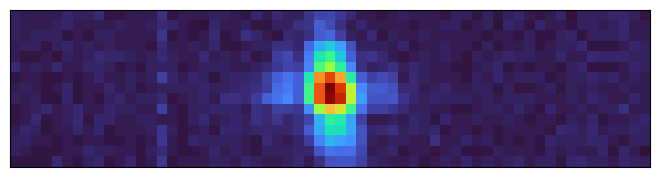

In [12]:
def gaussian(x, a, mu, sigma):
    return a * np.exp(-(x - mu)**2 / (2 * sigma**2))

def fit_gaussian(x,y):
    n = len(x)
    mean = sum(x * y) / sum(y)
    sigma = np.sqrt(sum(y * (x - mean)**2) / sum(y))
    # fit curve with gaussian
    popt,pcov = curve_fit(gaussian, x, y, p0=[max(y), mean, sigma])

    return popt, pcov

def fwhm_along_axis(y, spacing, plot = False):
    # Maximum normalization
    y_norm = [i/max(y) for i in y]
    # create x values for plot based on the intensity values y considering the spacing
    x = [(i) * spacing for i in range(len(y_norm))]
    y = y_norm-np.max(y_norm)/2
    # find fwhm of plot
    spline = UnivariateSpline(x, y , s=0)
    r1, r2 = spline.roots()
    fwhm = abs(abs(r1) - abs(r2))
    
    # return fwhm
    return [fwhm], y

from random import choice

from scipy.ndimage import zoom

random_point = choice(points[0])
random_point = [175, 248.0, 499.5]
print(random_point)
print(points)
bbox_size = 60
import cv2
#    z_spacing = metadata['sample_stage_step_size']
z_factor = z_spacing/xy_pixelsize
for c in range(1):
    c = 0
    bead = cropped_stack[c,:,int(random_point[1]-bbox_size/2):int(random_point[1]+bbox_size/2)+1, int(random_point[2]-bbox_size/2):int(random_point[2]+bbox_size/2)+1]
    max_coor = np.unravel_index(np.argmax(bead), bead.shape)
    xy_maxint = np.max(bead, axis=0)
    yz_maxint = np.max(bead, axis=1)
    
    y_line = xy_maxint[int(max_coor[1]),:]
    x_line = xy_maxint[:,int(max_coor[2])]
    z_line = yz_maxint[:,int(max_coor[2])]
    
    fwhm_x, x = fwhm_along_axis(x_line, xy_pixelsize)
    fwhm_y, y = fwhm_along_axis(y_line, xy_pixelsize)
    fwhm_z, z = fwhm_along_axis(z_line, z_spacing)
    
    xx = [(i) * xy_pixelsize for i in range(len(x_line))]
    xy = [(i) * xy_pixelsize for i in range(len(x_line))]
    xz = [(i) * z_spacing for i in range(len(z_line))]

    popt_x, pcov_x = fit_gaussian(xx, x_line)
    popt_y, pcov_y = fit_gaussian(xy, y_line)
    popt_z, pcov_y = fit_gaussian(xz, z_line)
    
    gaus_x = [i/max(gaussian(xx, *popt_x)) for i in gaussian(xx, *popt_x)]
    gaus_y = [i/max(gaussian(xy, *popt_y)) for i in gaussian(xy, *popt_y)]
    gaus_z = [i/max(gaussian(xz, *popt_z)) for i in gaussian(xz, *popt_z)]

    xx = [i - xx[gaus_x.index(max(gaus_x))] for i in xx]
    xy = [i - xy[gaus_y.index(max(gaus_y))] for i in xy]
    xz = [i - xz[gaus_z.index(max(gaus_z))] for i in xz]
    
    plt.figure(figsize=(5,5), dpi=200)
    plt.plot(xx, gaus_x, label='x', linewidth=3)#, marker='o', markersize=13)
    plt.plot(xy, gaus_y, label='y', linewidth=3)#, marker='^', markersize=13)
    plt.plot(xz, gaus_z, label='z', linewidth=3)#, marker='*', markersize=13)
    plt.xlim([-7.5, 7.5 ])
    plt.savefig(save_folder + '/' + f'bead_{c}_gaussian.svg', bbox_inches='tight', pad_inches=0)
    plt.close()
    print(fwhm_x, fwhm_y, fwhm_z)
    plt.imshow(np.sqrt(np.max(bead, axis=0)), cmap='turbo')
    plt.yticks([])
    plt.xticks([])
    plt.tight_layout(pad=0)
    plt.savefig(save_folder + '/' + f'bead_{c}_xy_open.png', bbox_inches='tight', pad_inches=0)
    bbox_size = 14
    z_max = np.unravel_index(np.argmax(bead), bead.shape)[0]
    print(np.max(bead, axis=1).shape)
    crop_zx = np.sqrt(np.max(bead, axis=1))[z_max-bbox_size//2:z_max+bbox_size//2+1,:]
    crop_zy = np.sqrt(np.max(bead, axis=2))[z_max-bbox_size//2:z_max+bbox_size//2+1,:]

    #height, width = crop_zx.shape 
    #crop_zx = zoom(crop_zx, (z_factor, 1), order=1)
    #crop_zy = zoom(crop_zy, (z_factor, 1), order=1)
    plt.imshow(crop_zx, cmap='turbo')
    plt.yticks([])
    plt.xticks([])
    plt.tight_layout(pad=0)
    plt.savefig(save_folder + '/' + f'bead_{c}_zx_open.png', bbox_inches='tight', pad_inches=0)

    plt.imshow(crop_zy, cmap='turbo')
    plt.yticks([])
    plt.xticks([])
    plt.tight_layout(pad=0)
    plt.savefig(save_folder + '/' + f'bead_{c}_zy_open.png', bbox_inches='tight', pad_inches=0)

In [103]:
bbox_size = 30
import cv2
#    z_spacing = metadata['sample_stage_step_size']
all_fwhm = {'x':[], 'y':[], 'z':[]}
z_factor = z_spacing/xy_pixelsize
for random_point in points[0]:

    for c in range(1):
        c = 0

        bead = cropped_stack[c,:,int(random_point[1]-bbox_size/2):int(random_point[1]+bbox_size/2)+1, int(random_point[2]-bbox_size/2):int(random_point[2]+bbox_size/2)+1]
        if 0 in bead.shape:
            continue
        max_coor = np.unravel_index(np.argmax(bead), bead.shape)
        xy_maxint = np.max(bead, axis=0)
        yz_maxint = np.max(bead, axis=1)
        
        y_line = xy_maxint[int(max_coor[1]),:]
        x_line = xy_maxint[:,int(max_coor[2])]
        z_line = yz_maxint[:,int(max_coor[2])]
        
        try:

            fwhm_x, x = fwhm_along_axis(x_line, xy_pixelsize)
            fwhm_y, y = fwhm_along_axis(y_line, xy_pixelsize)
            fwhm_z, z = fwhm_along_axis(z_line, z_spacing)
            all_fwhm['x'].append(fwhm_x[0])
            all_fwhm['y'].append(fwhm_y[0])
            all_fwhm['z'].append(fwhm_z[0])
        except ValueError:
            print('ValueError')
            continue

    


ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError
ValueError

In [109]:
print(np.mean(all_fwhm['x']))
print(np.std(all_fwhm['x']))

print(np.mean(all_fwhm['y']))
print(np.std(all_fwhm['y']))

print(np.average(all_fwhm['z']))
print(np.std(all_fwhm['z']))

1.0577238426787912
0.04463674543795621
1.0359268057078657
0.07485207297256016
4.2232871180676455
0.7547089389449028
